In [11]:
import numpy as np
from create_cat import assign_balrog_zbins, merge_bagpipes, merge_balrog_bagpipes, apply_nzs_weighting

# Create Balrog-Bagpipes catalog 

## Load Balrog galaxies and assign redshift bins and n(z)s

In [2]:
balrog_data = assign_balrog_zbins()

Running assign Balrog to zbins

reading pcchat...
Illegal slicing argument for scalar dataspace
just putting None
reading zp...
...success
zeropoint = 30
reading columns...
...success
reading SOMs...
...success
using overlap_weight as stored in CellMap.data

Loaded Balrog entries: 2417437
Unique Balrog sources: 267229

Assigned wide SOM using unsheared fluxes
Assigned wide SOM using sheared_1p fluxes
Assigned wide SOM using sheared_1m fluxes
Assigned wide SOM using sheared_2p fluxes
Assigned wide SOM using sheared_2m fluxes
Completed wide SOM assignment
Completed deep SOM assignment

Assigned tomographic bins
Assigned photometric redshift cell (pzc)


## Load Bagpipes physical properties

In [3]:
bagpipes_data = merge_bagpipes()

Running merge Bagpipes runs

Length of Bagpipes catalog 1: 489046
Length of Bagpipes catalog 2: 358370
Length of Bagpipes catalog 3: 358371
Length of Bagpipes catalog 4: 358370
Length of Bagpipes catalog 5: 358371
Length of Bagpipes extra COSMOS catalog: 57997

Length of merged Bagpipes catalogs: 1979779


## Merge Balrog-Bagpipes

In [4]:
data = merge_balrog_bagpipes(balrog_data, bagpipes_data)

Running merge Balrog with Bagpipes

Length of Balrog single sources matching by coordinates with Bagpipes: 267229
Length of Balrog data matching with Bagpipes: 2417437


## Reweight n(z)s

In [12]:
data['overlap_weight'] = apply_nzs_weighting(data['unsheared/snr'], data['unsheared/T'], data['unsheared/size_ratio'])
data['pzc_weighted'] = data['pzc'] * data['overlap_weight']/np.mean(data['overlap_weight']) # Mean weight is 1

Shear weights adjusted
Response weights adjusted


## Save catalog

In [13]:
file_out = '/global/cfs/cdirs/des/elisa/IA_decisiontree/decisiontree_data/balrog-bagpipes.pkl'
data.to_pickle(file_out)

# Load Balrog-Bagpipes catalog

In [1]:
import numpy as np
import pickle

In [2]:
file = '/global/cfs/cdirs/des/elisa/IA_decisiontree/decisiontree_data/balrog-bagpipes.pkl'
data = pickle.load(open(file, 'rb'), encoding='latin1')
print(f'Length of Balrog-Bagpipes catalog: {len(data)}')

Length of Balrog-Bagpipes catalog: 2417437


In [3]:
data = data.dropna(subset=['stell_best', 'ssfr_best'])
print(f'Length of Balrog-Bagpipes catalog (no nan): {len(data)}')

Length of Balrog-Bagpipes catalog (no nan): 2417396


In [5]:
for i in range(4):
    print(f'Length of Balrog-Bagpipes Bin{i}: {len(data[data["bin"]==i])}')

Length of Balrog-Bagpipes Bin0: 613544
Length of Balrog-Bagpipes Bin1: 608122
Length of Balrog-Bagpipes Bin2: 605458
Length of Balrog-Bagpipes Bin3: 590272


In [ ]:
from scipy.signal import savgol_filter
import scipy.interpolate as interp
import copy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

colors = list(matplotlib.colors.TABLEAU_COLORS.keys())

plt.rcParams.update({
    'font.family':'serif',
    'font.size':14.0,
    'axes.labelsize': 'large',
    'xtick.labelsize':'large',
    'ytick.labelsize':'large',
    'axes.titlesize':'large',
    'legend.fontsize': 'large',
    'lines.linewidth':1.8,
    'patch.linewidth':1.8,})

### n(z)s

In [6]:
pz_bin = np.array([np.mean(data['pzc_weighted'][data['bin'] == i], axis=0) for i in range(4)])
z = np.linspace(0, 6, len(pz_bin[0]))
meanz_bin = np.array([mean_z(pz_bin[i]) for i in range(4)])

pz_bin_pileup = np.array([pile_up(pz_bin[i]) for i in range(4)])
z3 = np.linspace(0, 2.99, len(pz_bin_pileup[0]))

dz = np.append(np.diff(z), 0.01)    
pz_bin_smooth = np.array([pz_normalization(dz, remove_spikes_savgol(z, pz_bin[i])) for i in range(4)])

dz3 = np.append(np.diff(z3), 0.01)    
pz_bin_pileup_smooth = np.array([pz_normalization(dz3, remove_spikes_savgol(z3, pz_bin_pileup[i])) for i in range(4)])
meanz_bin_pileup_smooth = np.array([mean_z(pz_bin_pileup_smooth[i]) for i in range(4)])

print('Mean z:               ', meanz_bin)
print('Mean z smooth:        ', np.array([mean_z(pz_bin_smooth[i]) for i in range(4)]))
print('Mean z pileup:        ', np.array([mean_z(pz_bin_pileup[i]) for i in range(4)]))
print('Mean z pileup smooth: ', meanz_bin_pileup_smooth)

Mean z:                [0.33973083 0.50761473 0.73457933 0.91327462]
Mean z smooth:         [0.33935739 0.50734721 0.73453565 0.91315606]
Mean z pileup:         [0.33933981 0.50698806 0.73399801 0.9124817 ]
Mean z pileup smooth:  [0.33850784 0.50630387 0.73372052 0.91196903]


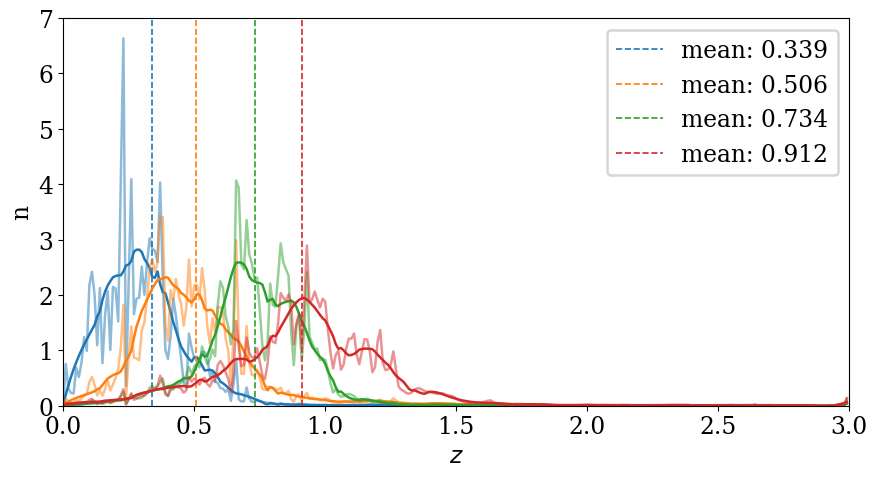

In [7]:
fig = plt.figure(figsize=(9, 5))

for i in range(4):
    plt.plot(z3, pz_bin_pileup[i], alpha=0.5, color=colors[i])
    plt.plot(z3, pz_bin_pileup_smooth[i], color=colors[i])
    plt.vlines(meanz_bin_pileup_smooth[i], 0, 10, ls='--', lw=1.2, color=colors[i], 
               label='mean: '+'{:.3f}'.format(meanz_bin_pileup_smooth[i]))
    
plt.ylim(0, 7)
plt.xlim(0, 3)
plt.ylabel('n')
plt.xlabel(r'$z$')
plt.legend()

plt.tight_layout()
fig.patch.set_alpha(1.0)
#plt.savefig('.png', dpi=200, bbox_inches='tight')
plt.show()

In [8]:
calib_dz = np.array([0.015, 0.011, 0.008, 0.015]) # from Y3 photoz paper 
deltaz   = np.array([0.018, 0.015, 0.011, 0.017])

print('Photo-z calibration uncertainty:', calib_dz)

Photo-z calibration uncertainty: [0.015 0.011 0.008 0.015]


### Physical properties

In [9]:
mass_median = [np.median(data['stell_best'][data['bin']==i]) for i in range(4)]
ssfr_median = [np.median(data['ssfr_best'][data['bin']==i]) for i in range(4)]

print('Median stellar mass:', mass_median)
print('Median ssfr:      ', ssfr_median)

Median stellar mass: [9.424247, 9.778841, 10.196053, 10.106406]
Median ssfr:       [-9.485851, -9.4915905, -9.451447, -9.419115]


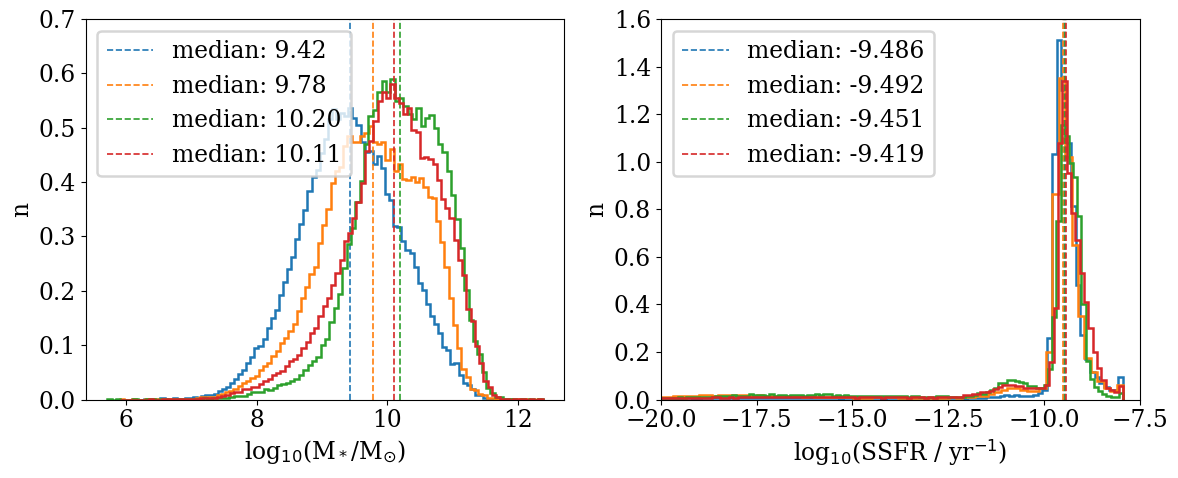

In [10]:
fig = plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
for i in range(4):
    plt.hist(data['stell_best'][data['bin']==i], bins=100, histtype='step', density=True)
    plt.vlines(mass_median[i], 0, 2, ls='--', lw=1.2, color=colors[i], label='median: '+'{:.2f}'.format(mass_median[i]))
plt.ylim(0, 0.7)
plt.ylabel('n')
plt.xlabel(r'log$_{10}$(M$_*$/M$_{\odot}$)')
plt.legend()

plt.subplot(1,2,2)
for i in range(4):
    plt.hist(data['ssfr_best'][data['bin']==i], bins=500, histtype='step', density=True)#, label=f'bin {i}')
    plt.vlines(ssfr_median[i], 0, 2, ls='--', lw=1.2, color=colors[i], label='median: '+'{:.3f}'.format(ssfr_median[i]))
plt.ylim(0, 1.6)
plt.xlim(-20, -7.5)
plt.ylabel('n')
plt.xlabel(r'log$_{10}$(SSFR / yr$^{-1}$)')
plt.legend()

plt.tight_layout()
fig.patch.set_alpha(1.0)
#plt.savefig('.png', dpi=200, bbox_inches='tight')
plt.show()

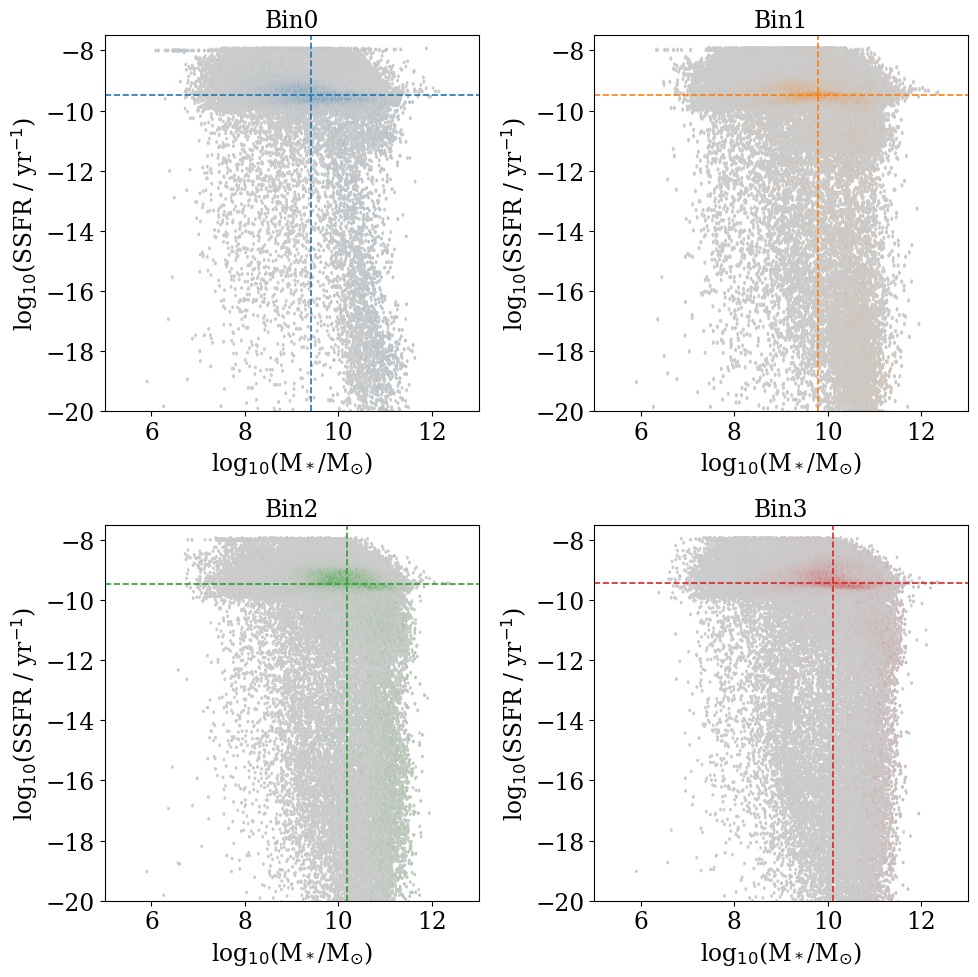

In [11]:
cmap_blue = LinearSegmentedColormap.from_list("gray_to_blue", [(0.8, 0.8, 0.8), (31/255, 119/255, 180/255)], N=256)
cmap_orange = LinearSegmentedColormap.from_list("gray_to_orange", [(0.8, 0.8, 0.8), (255/255, 127/255, 14/255)], N=256)
cmap_green = LinearSegmentedColormap.from_list("gray_to_orange", [(0.8, 0.8, 0.8), (44/255, 160/255, 44/255)], N=256)
cmap_red = LinearSegmentedColormap.from_list("gray_to_orange", [(0.8, 0.8, 0.8), (214/255, 39/255, 40/255)], N=256)
cmaps = [cmap_blue, cmap_orange, cmap_green, cmap_red]

fig = plt.figure(figsize=(10, 10))

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(f'Bin{i}')
    plt.hexbin(data['stell_best'][data['bin']==i], data['ssfr_best'][data['bin']==i], gridsize=1500, cmap=cmaps[i], mincnt=1)
    plt.vlines(mass_median[i], -20, -7.5, ls='--', lw=1.2, color=colors[i], label='median: '+'{:.2f}'.format(mass_median[i]))
    plt.hlines(ssfr_median[i], 5, 13, ls='--', lw=1.2, color=colors[i], label='median: '+'{:.2f}'.format(ssfr_median[i]))
    plt.xlim(5, 13)
    plt.ylim(-20, -7.5)
    plt.xlabel(r'log$_{10}$(M$_*$/M$_{\odot}$)')
    plt.ylabel(r'log$_{10}$(SSFR / yr$^{-1}$)')

plt.tight_layout()
fig.patch.set_alpha(1.0)
#plt.savefig('.png', dpi=200, bbox_inches='tight')
plt.show()